In [58]:
from datetime import datetime, timedelta
import concurrent.futures

import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [59]:
# Debugging Flag (Set to True if you want to print intermediate values)
DEBUG = False

# Function to calculate trading days between two dates
def trading_days(start_date, end_date):
    """
    Calculate the number of trading days between two dates, excluding weekends.
    """
    total_days = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' frequency for business days (no weekends)
    return len(total_days)
    
# Refactored: Compute d1 and d2
def compute_d1_d2(S0, K, T, r, sigma):
    """
    Helper function to compute d1 and d2 used in the Greeks calculations.
    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Optional Debugging
    if DEBUG:
        print(f"d1: {d1}, d2: {d2}")
    
    return d1, d2

# Adjusted Delta
def delta(S0, K, T, r, sigma, option_type='call', N=1):
    """
    Compute Delta of an option, adjusted for contract size N.
    """
    d1, _ = compute_d1_d2(S0, K, T, r, sigma)
    if option_type == 'call':
        return norm.cdf(d1) / N
    elif option_type == 'put':
        return (norm.cdf(d1) - 1) / N

# Adjusted Gamma
def gamma(S0, K, T, r, sigma, N=1):
    """
    Compute Gamma of an option, adjusted for contract size N.
    """
    d1, _ = compute_d1_d2(S0, K, T, r, sigma)
    return (norm.pdf(d1) / (S0 * sigma * np.sqrt(T))) / N

# Adjusted Vega
def vega(S0, K, T, r, sigma, N=1):
    """
    Compute Vega of an option, adjusted for contract size N.
    """
    d1, _ = compute_d1_d2(S0, K, T, r, sigma)
    return (S0 * norm.pdf(d1) * np.sqrt(T)) / N

# Adjusted Theta with refactoring for consistency
def theta(S0, K, T, r, sigma, option_type='call', N=1):
    """
    Compute Theta of an option, adjusted for contract size N.
    """
    d1, d2 = compute_d1_d2(S0, K, T, r, sigma)
    
    term1 = (-S0 * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
    term3 = r * K * np.exp(-r * T)
    
    if option_type == 'call':
        term2 = term3 * norm.cdf(d2)
        return (term1 - term2) / N
    elif option_type == 'put':
        term2 = term3 * norm.cdf(-d2)
        return (term1 + term2) / N

# Adjusted Black-Scholes pricing function
def black_scholes(S0, K, T, r, sigma, option_type='call', N=1):
    """
    Computes the Black-Scholes price per share for a European option, 
    divided by the number of shares the option represents (N).
    
    Parameters:
    - S0: Current price of the underlying asset
    - K: Strike price of the option
    - T: Time to expiration (in years)
    - r: Risk-free interest rate (annualized)
    - sigma: Volatility of the underlying asset (annualized)
    - option_type: 'call' for call options, 'put' for put options
    - N: Number of shares the option represents (contract size)

    Returns:
    - price_per_share: The price of the option per share, adjusted for contract size
    """
    # Input validation
    if T <= 0 or sigma <= 0 or N <= 0:
        raise ValueError(f"Time to expiration {T}, volatility {sigma}, and contract size {N} must be positive.")

    # Calculate d1 and d2 using helper function
    d1, d2 = compute_d1_d2(S0, K, T, r, sigma)
    
    if option_type == 'call':
        # Call option price per share
        price_per_share = (S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)) / N
    elif option_type == 'put':
        # Put option price per share
        price_per_share = (K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)) / N
    else:
        raise ValueError("Invalid option_type. Choose 'call' or 'put'.")
    
    # Optional Debugging
    if DEBUG:
        print(f"Price per share: {price_per_share}")
    
    return price_per_share

def simulate_volatility(T, time_steps, sigma_mean, kappa, xi, initial_vol, min_vol=0):
    """
    Simulate mean-reverting volatility using the Ornstein-Uhlenbeck process.
    
    Parameters:
    - T: Total time to maturity (in years)
    - time_steps: Number of time steps in the simulation
    - sigma_mean: Long-term mean volatility
    - kappa: Speed of reversion
    - xi: Volatility of volatility
    - initial_vol: Starting value of volatility
    - min_vol: Minimum allowed volatility
    
    Returns:
    - volatility: Simulated volatility path
    """
    dt = T / time_steps
    volatility = np.zeros(time_steps)
    volatility[0] = max(initial_vol, min_vol)  # Start at the specified initial volatility, ensuring it's non-negative

    for t in range(1, time_steps):
        dW = np.sqrt(dt) * np.random.normal(size=1)  # Increment in the Wiener process
        volatility[t] = volatility[t-1] + kappa * (sigma_mean - volatility[t-1]) * dt + xi * dW
        
        # Ensure volatility does not fall below the minimum value
        if volatility[t] < min_vol:
            volatility[t] = min_vol

    return volatility

# Test example (debugging active)
current_date = datetime(2024, 9, 14)
maturity_date = datetime(2025, 9, 19)

# Compute the number of trading days to expiration
trading_days_to_expiration = trading_days(current_date, maturity_date)

# Approximate number of trading days in a year (typically around 252)
trading_days_in_year = 252

# Calculate time to expiration in years, accounting for only trading days
T = trading_days_to_expiration / trading_days_in_year

DEBUG = True
forex_rate = 1.11  # Forex rate (foreign currency to domestic currency)
S0 = 19509.9417  # Underlying price
K = 18000   # Strike price
r = 0.0441  # Risk-free rate
sigma = 0.2092  # Volatility
N = 100   # Number of shares (parity)

# Run a test for call option
print(f"Time to maturit: {T} year(s).")
print("Call Option Price:", black_scholes(S0, K, T, r, sigma, option_type='call', N=N))
print("Delta:", delta(S0, K, T, r, sigma, option_type='call', N=N))
print("Gamma:", gamma(S0, K, T, r, sigma, N=N))
print("Vega:", vega(S0, K, T, r, sigma, N=N))
print("Theta:", theta(S0, K, T, r, sigma, option_type='call', N=N))


Time to maturit: 1.0515873015873016 year(s).
d1: 0.6989225327162639, d2: 0.4843943534890592
Price per share: 29.951528123124007
Call Option Price: 29.951528123124007
d1: 0.6989225327162639, d2: 0.4843943534890592
Delta: 0.0075769977753537355
d1: 0.6989225327162639, d2: 0.4843943534890592
Gamma: 7.466118934748075e-07
d1: 0.6989225327162639, d2: 0.4843943534890592
Vega: 62.519264551782406
d1: 0.6989225327162639, d2: 0.4843943534890592
Theta: -11.417007494368255


In [60]:
DEBUG = False

# Parameters
S0 = 19515  # Current price of the underlying asset in foreign currency
forex_rate = 1.11  # Forex rate
K = 18000  # Adjust strike price to domestic currency
N = 100  # Parity (number of shares)
T_maturity = 5 / 252  # Time to expiration (in years)
historical_volatility = 0.1327  # Historical volatility (13.27%)

# Mean Reversion Parameters
sigma_mean = historical_volatility  # Long-term mean volatility
kappa = 1.0  # Speed of reversion (adjust as needed)
xi = 0.2  # Volatility of volatility (adjust as needed)
initial_vol = 0.2092  # Starting value of volatility (adjust as needed)

# Define the time series for underlying prices
time_steps = 500  # Number of time steps
min_time = 1e-5  # Small positive value to avoid zero
time_series = np.linspace(T_maturity, min_time, time_steps)  # Time from maturity to a small positive value

# Display time series for checking
if DEBUG:
    display(time_series)

# Generate underlying price series based on time
price_changes = np.linspace(-3000, 2000, time_steps)  # Price changes over time
time_series_prices = K + price_changes  # Underlying prices over time

# Parameters for noise
price_noise_std_dev = 100  # Standard deviation of the noise for price
interest_rate_noise_std_dev = 0.01  # Standard deviation of the noise for interest rate

# Generate noise for price and interest rate
price_noise = np.random.normal(loc=0, scale=price_noise_std_dev, size=time_steps)
interest_rate_noise = np.random.normal(loc=0, scale=interest_rate_noise_std_dev, size=time_steps)

# Add noise to price time series
time_series_prices_noisy = time_series_prices + price_noise

# Simulate mean-reverting volatility
volatility_series = simulate_volatility(T_maturity, time_steps, sigma_mean, kappa, xi, initial_vol, 1e-6)

# Interest rate schedule (falling from 4.41% to 2%)
initial_r = 0.0441  # Initial interest rate
final_r = 0.025  # Final interest rate
interest_rates = np.linspace(initial_r, final_r, time_steps)  # Linearly interpolated rates
interest_rates_noisy = interest_rates + interest_rate_noise

# Compute option metrics with mean-reverting volatility
option_prices = np.array([black_scholes(price, K, T, r, vol, option_type='call', N=N) 
                          for price, T, r, vol in zip(time_series_prices_noisy, time_series, interest_rates_noisy, volatility_series)]) / forex_rate

deltas = np.array([delta(price, K, T, r, vol, option_type='call', N=1) 
                   for price, T, r, vol in zip(time_series_prices_noisy, time_series, interest_rates_noisy, volatility_series)])

# Compute leverage
leverage = deltas * time_series_prices_noisy / option_prices

# Display results if DEBUG is enabled
if DEBUG:
    print("Time Series Prices (Noisy):", time_series_prices_noisy)
    print("Volatility Series:", volatility_series)
    print("Option Prices:", option_prices)
    print("Deltas:", deltas)
    print("Leverage:", leverage)


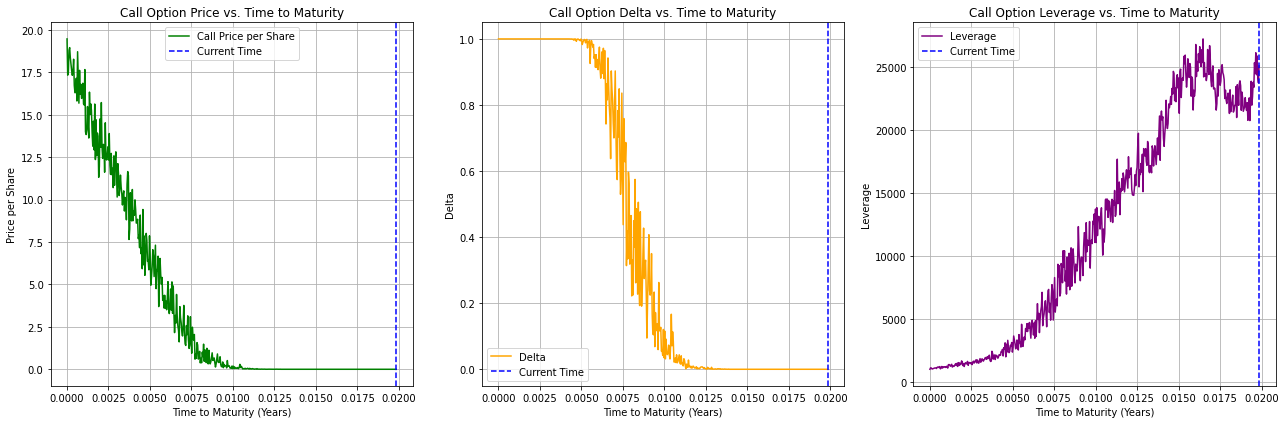

In [61]:
# Plotting
plt.figure(figsize=(18, 6))

# Plot Call Option Prices
plt.subplot(1, 3, 1)
plt.plot(time_series, option_prices, label='Call Price per Share', color='green')
plt.axvline(x=T_maturity, color='blue', linestyle='--', label='Current Time')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Price per Share')
plt.title('Call Option Price vs. Time to Maturity')
plt.legend()
plt.grid(True)

# Plot Deltas
plt.subplot(1, 3, 2)
plt.plot(time_series, deltas, label='Delta', color='orange')
plt.axvline(x=T_maturity, color='blue', linestyle='--', label='Current Time')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Delta')
plt.title('Call Option Delta vs. Time to Maturity')
plt.legend()
plt.grid(True)

# Plot Leverage
plt.subplot(1, 3, 3)
plt.plot(time_series, leverage, label='Leverage', color='purple')
plt.axvline(x=T_maturity, color='blue', linestyle='--', label='Current Time')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Leverage')
plt.title('Call Option Leverage vs. Time to Maturity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [62]:
DEBUG = False

# Parameters
S0 = 19515  # Current price of the underlying asset in foreign currency
forex_rate = 1.11  # Forex rate
K = 18000  # Adjust strike price to domestic currency
N = 100  # Parity (number of shares)
T_maturity = (datetime(2025, 9, 19) - datetime(2024, 9, 14)).days / 365  # Time to expiration (in years)
historical_volatility = 0.1327  # Historical volatility (13.27%)

# Mean Reversion Parameters for Volatility
sigma_mean = historical_volatility  # Long-term mean volatility
kappa = 1.0  # Speed of reversion
xi = 0.05  # Volatility of volatility
initial_vol = 0.2092  # Starting value of volatility
min_vol = 1e-5  # Minimum allowed volatility

# Parameters for Monte Carlo Simulation
num_simulations = 1000  # Number of simulation paths
time_steps = (datetime(2025, 9, 19) - datetime(2024, 9, 14)).days  # Number of time steps per path
dt = T_maturity / time_steps  # Time increment per step
price_noise_std_dev = 100  # Standard deviation of the noise for price
interest_rate_noise_std_dev = 0.01  # Standard deviation of the noise for interest rate

def simulate_interest_rates(T, num_steps, initial_r, final_r, noise_std_dev):
    dt = T / num_steps
    r_path = np.linspace(initial_r, final_r, num_steps) + np.random.normal(0, noise_std_dev, num_steps)
    return r_path

def simulate_random_walk_price(S0, num_steps, annual_growth_rate, volatility, dt):
    price_path = np.zeros(num_steps)
    price_path[0] = S0  # Starting value of the price
    
    for t in range(1, num_steps):
        # Generate random noise for this time step
        epsilon = np.random.normal(0, 1)
        
        # Apply the random walk formula with drift and volatility
        growth_factor = (annual_growth_rate - 0.5 * volatility[t] **2) * dt
        random_shock = volatility[t] * epsilon * np.sqrt(dt)
        
        price_path[t] = price_path[t-1] * np.exp(growth_factor + random_shock)
    
    return price_path

# Monte Carlo Simulation
def monte_carlo_simulation(num_simulations, time_steps, T_maturity, K, N, price_noise_std_dev, interest_rate_noise_std_dev, annual_growth_rate):
    dt = T_maturity / time_steps
    results = []
    
    for _ in range(num_simulations):
        # Generate paths for price, volatility, and interest rates
        vol_path = simulate_volatility(T_maturity, time_steps, sigma_mean, kappa, xi, initial_vol, min_vol)
        interest_rate_path = simulate_interest_rates(T_maturity, time_steps, 0.0441, 0.02, interest_rate_noise_std_dev)
        price_path = simulate_random_walk_price(S0, time_steps, annual_growth_rate, vol_path, dt)
        
        # Compute option metrics
        option_prices = np.array([black_scholes(price, K, T_maturity - t * dt, r, vol, option_type='call', N=N)
                                  for t, price, r, vol in zip(range(time_steps), price_path, interest_rate_path, vol_path)]) / forex_rate
        deltas = np.array([delta(price, K, T_maturity - t * dt, r, vol, option_type='call', N=N)
                           for t, price, r, vol in zip(range(time_steps), price_path, interest_rate_path, vol_path)])
        
        # Calculate leverage
        leverage = deltas * price_path / option_prices
        
        # Store results for this simulation
        results.append({
            'price_path': price_path,
            'vol_path': vol_path,
            'interest_rate_path': interest_rate_path,
            'option_prices': option_prices,
            'deltas': deltas,
            'leverage': leverage
        })
    
    return results

# Run Monte Carlo Simulation
annual_growth_rate = 0.20  # Annual growth rate of 10%
results = monte_carlo_simulation(num_simulations, time_steps, T_maturity, K, N, price_noise_std_dev, interest_rate_noise_std_dev, annual_growth_rate)

DEBUG = True

# Display results if DEBUG is enabled
if DEBUG:
    for i, result in enumerate(results[:5]):  # Display results for first 5 simulations
        print(f"Simulation {i+1}:")
        print("Price Path:", result['price_path'])
        print("Volatility Path:", result['vol_path'])
        print("Interest Rate Path:", result['interest_rate_path'])
        print("Option Prices:", result['option_prices'])
        print("Deltas:", result['deltas'])
        print("Leverage:", result['leverage'])
        print()


/tmp/ipykernel_95932/1949893799.py:64: RuntimeWarning: invalid value encountered in true_divide
  leverage = deltas * price_path / option_prices


Simulation 1:
Price Path: [19515.         19821.62195465 20138.11001129 19970.73565088
 20002.88533657 20379.89273423 20056.33047759 20136.67414383
 20352.70182265 20419.38429311 20293.36527567 20334.4507255
 19924.08991856 20206.96935589 20147.43790028 20216.06878928
 20352.44233471 19937.75113538 19878.30361748 19899.28059096
 19700.07344625 19763.92221844 19583.97209556 19573.97262437
 19299.96807639 19379.84007671 19705.95055656 19992.43252426
 19839.43305946 19808.80750151 20204.70661347 19975.63102529
 20073.01971217 20166.40883778 20100.21551354 20302.82326992
 20236.60733929 20273.7220938  20221.09157122 20257.55503731
 20234.67283322 20096.30900248 20264.63370278 20381.40152711
 20231.4195086  20535.18442089 20654.73283553 20586.81714948
 20547.01743394 20651.96453685 20782.76694084 20824.76514878
 21309.40201346 21254.70394564 21058.28429984 21236.79693104
 20833.74031693 20854.54345173 20811.17325158 21065.53690173
 21139.57620278 21294.13881844 21671.97748611 21678.19057157

In [63]:
# Run Monte Carlo Simulation
final_prices = [e['option_prices'][-1] - e['option_prices'][0] for e in results]

count_profitable = 0

for fp in final_prices:
    if fp > 0:
        count_profitable = count_profitable + 1

print(f'Probability of profitability: {count_profitable / len(final_prices):.2%}. Expected gain is {np.mean(final_prices)}. An average gain of {(np.mean(final_prices) / results[0]["option_prices"][0]):.2%}. '
      f'A megian gain of {(np.median(final_prices) / results[0]["option_prices"][0]):.2%}. '
      f'Max gain is {np.max(final_prices) / results[0]["option_prices"][0]:.2%}')

Probability of profitability: 75.20%. Expected gain is 28.394704232410653. An average gain of 109.11%. A megian gain of 100.22%. Max gain is 917.46%


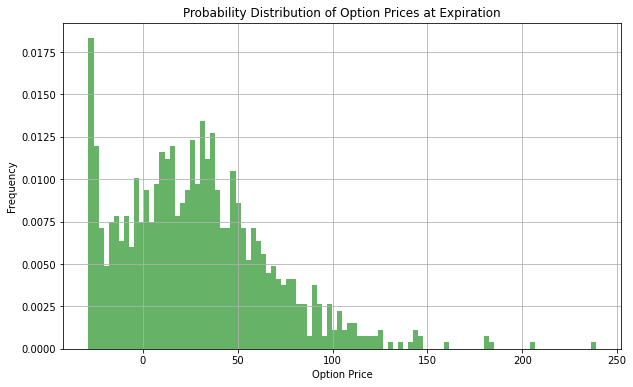

In [64]:
# Plot the distribution of the final option prices
plt.figure(figsize=(10, 6))
plt.hist(final_prices, bins=100, density=True, alpha=0.6, color='g')
plt.title('Probability Distribution of Option Prices at Expiration')
plt.xlabel('Option Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Using real NASDAQ price data.

In [68]:
DEBUG = False

# Load the historical NDX data
file_path = 'data/ndx_prices_time_series_all.csv'
ndx_data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime and sort by date
ndx_data['Date'] = pd.to_datetime(ndx_data['Date'], format='%m/%d/%Y')
ndx_data = ndx_data.sort_values(by='Date')

# Ensure that the 'Price' column is converted to float
ndx_data['Price'] = ndx_data['Price'].str.replace(',', '').astype(float)

# Extract the daily prices for NDX
daily_prices = ndx_data['Price'].values

# Ensure we have at least enough prices for the time steps
time_steps = 252  # Number of time steps (1 year)
assert len(daily_prices) >= time_steps, "Not enough daily prices for the simulation period."

# Parameters
S0 = daily_prices[0]  # Starting value of the price is the first day in the dataset
forex_rate = 1.11  # Forex rate
K = 18000  # Adjust strike price to domestic currency
N = 100  # Parity (number of shares)
T_maturity = 1  # Time to expiration (in years)
T_periodicity = 63 # Periodicity of investments.
historical_volatility = 0.1327  # Historical volatility (13.27%)

# Mean Reversion Parameters for Volatility
sigma_mean = historical_volatility  # Long-term mean volatility
kappa = 1.0  # Speed of reversion
xi = 0.05  # Volatility of volatility
initial_vol = 0.2092  # Starting value of volatility
min_vol = 1e-5  # Minimum allowed volatility

# Parameters for Monte Carlo Simulation
num_simulations = 100  # Number of simulation paths
dt = T_maturity / time_steps  # Time increment per step
price_noise_std_dev = 25  # Standard deviation of the noise for price
interest_rate_noise_std_dev = 0.01  # Standard deviation of the noise for interest rate
annual_growth_rate = 0.10  # Annual growth rate of 10%

def simulate_interest_rates(T, num_steps, initial_r, final_r, noise_std_dev):
    dt = T / num_steps
    r_path = np.linspace(initial_r, final_r, num_steps) + np.random.normal(0, noise_std_dev, num_steps)
    return r_path

def simulate_volatility(T, num_steps, sigma_mean, kappa, xi, initial_vol, min_vol):
    dt = T / num_steps
    vol_path = np.zeros(num_steps)
    vol_path[0] = initial_vol
    
    for t in range(1, num_steps):
        vol_path[t] = vol_path[t-1] + kappa * (sigma_mean - vol_path[t-1]) * dt + xi * np.random.normal(0, np.sqrt(dt))
        vol_path[t] = max(vol_path[t], min_vol)  # Ensure non-negative volatility
    
    return vol_path

def compute_num_quarters(daily_prices, trading_days_per_quarter=63):
    total_days = len(daily_prices)
    num_quarters = total_days // trading_days_per_quarter
    return num_quarters

# Monte Carlo Simulation
def monte_carlo_simulation(num_simulations, time_steps, T_maturity, K, N, daily_prices, price_noise_std_dev, interest_rate_noise_std_dev, annual_growth_rate):
    dt = T_maturity / time_steps
    num_quarters = compute_num_quarters(daily_prices, trading_days_per_quarter=T_periodicity)
    results = []

    print(f"Number of quarters: {num_quarters}")
    
    for i in range(num_quarters):
        for i in range(num_simulations):
            # Use the actual daily prices for the price path
            price_path = daily_prices[i * T_periodicity:i * T_periodicity + time_steps]

            # Adjust strike price to be ATM.
            K = price_path[0]

            # # Adjust strike price to be 10% ITM.
            # K = (2 / 3) * price_path[0]

            # # Adjust strike price to be 10% OTM.
            # K = 1.1 * price_path[0]
            
            # Generate paths for volatility and interest rates
            vol_path = simulate_volatility(T_maturity, time_steps, sigma_mean, kappa, xi, initial_vol, min_vol)
            interest_rate_path = simulate_interest_rates(T_maturity, time_steps, 0.0441, 0.02, interest_rate_noise_std_dev)
            
            # Compute option metrics
            option_prices = np.array([black_scholes(price, K, T_maturity - t * dt, r, vol, option_type='call', N=N)
                                    for t, price, r, vol in zip(range(time_steps), price_path, interest_rate_path, vol_path)]) / forex_rate
            deltas = np.array([delta(price, K, T_maturity - t * dt, r, vol, option_type='call', N=N)
                            for t, price, r, vol in zip(range(time_steps), price_path, interest_rate_path, vol_path)])
            
            # Calculate leverage
            leverage = deltas * price_path / option_prices
            
            # Store results for this simulation
            results.append({
                'price_path': price_path,
                'vol_path': vol_path,
                'interest_rate_path': interest_rate_path,
                'option_prices': option_prices,
                'deltas': deltas,
                'leverage': leverage
            })
    
    return results

# Run Monte Carlo Simulation using the actual daily prices
results = monte_carlo_simulation(num_simulations, time_steps, T_maturity, K, N, daily_prices, price_noise_std_dev, interest_rate_noise_std_dev, annual_growth_rate)

DEBUG = False

# Display results if DEBUG is enabled
if DEBUG:
    for i, result in enumerate(results[:5]):  # Display results for first 5 simulations
        print(f"Simulation {i+1}:")
        print("Price Path:", result['price_path'])
        print("Volatility Path:", result['vol_path'])
        print("Interest Rate Path:", result['interest_rate_path'])
        print("Option Prices:", result['option_prices'])
        print("Deltas:", result['deltas'])
        print("Leverage:", result['leverage'])
        print()


Number of quarters: 79


/tmp/ipykernel_95932/571788053.py:98: RuntimeWarning: invalid value encountered in true_divide
  leverage = deltas * price_path / option_prices


IndexError: index 0 is out of bounds for axis 0 with size 0

Probability of profitability: 62.89%
Expected gain: 0.11
Annualized average gain: 108.23%
Median gain: 44.04%
Max gain: 726.33%
Five years expected gain: 3814.55%
Probability of losing 100%: 9.42%
Expected loss when at a loss: -64.97%
Expected gain when realizing a gain: 143.59%


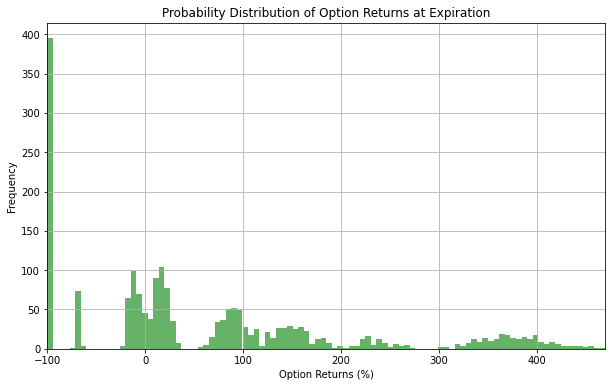

<Figure size 432x288 with 0 Axes>

In [42]:
# Run Monte Carlo Simulation
final_prices = [e['option_prices'][-1] - e['option_prices'][0] for e in results]
final_prices_returns = [(e['option_prices'][-1] / e['option_prices'][0] - 1) * 100.0 for e in results]

# Count the number of profitable outcomes
count_profitable = sum(1 for fp in final_prices if fp > 0)

# Count the number of times there's a 100% loss (final price return equals -1)
count_total_loss = sum(1 for r in final_prices_returns if r <= -100.0)

# Calculate the probability of a total loss
probability_total_loss = count_total_loss / len(final_prices_returns)

# Filter losses and gains
losses = [fp for fp in final_prices_returns if fp <= 0]
gains = [fp for fp in final_prices_returns if fp > 0]

# Expected loss: average of the losses
expected_loss = np.mean(losses) if len(losses) > 0 else 0

# Expected gain: average of the gains
expected_gain = np.mean(gains) if len(gains) > 0 else 0

# Compute the annualized gain based on the mean final price
initial_price = results[0]["option_prices"][0]
mean_final_price = np.mean(final_prices)
annualized_gain = mean_final_price / initial_price

# Output probability of profitability and gains
print(f'Probability of profitability: {count_profitable / len(final_prices):.2%}')
print(f'Expected gain: {np.mean(final_prices):.2f}')
print(f'Annualized average gain: {annualized_gain:.2%}')
print(f'Median gain: {(np.median(final_prices) / initial_price):.2%}')
print(f'Max gain: {np.max(final_prices) / initial_price:.2%}')
print(f'Five years expected gain: {((1 + annualized_gain) ** 5) - 1:.2%}')
print(f"Probability of losing 100%: {probability_total_loss:.2%}")
print(f'Expected loss when at a loss: {expected_loss:.2f}%')
print(f'Expected gain when realizing a gain: {expected_gain:.2f}%')

# Plot the distribution of the final option price returns
plt.figure(figsize=(10, 6))
plt.hist(final_prices_returns, bins=100, density=False, alpha=0.6, color='g')
plt.title('Probability Distribution of Option Returns at Expiration')
plt.xlabel('Option Returns (%)')
plt.ylabel('Frequency')
plt.xlim([-100.0, np.array(final_prices_returns).max()])
plt.grid(True)
plt.show()

# Save the plot as a PDF
plt.savefig('plots/return_ndx_option_strategy_quarterly_10_otm.pdf', format='pdf')
